In [1]:
# %pip install -U lightgbm==3.3.2

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [2]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("../") # path to the `src`` folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [3]:
from src.data import DataHelper
from src.data.metrics import map_at_k, hr_at_k, recall_at_k

from src.retrieval.rules import (
    OrderHistory,
    ALS,
    BPR,
    UserGroupTimeHistory,
    OrderHistoryDecay,
    ItemPair,
    TimeHistory,
    ItemCF,
    UserGroupItemCF
)
from src.retrieval.collector import RuleCollector

from src.features import cum_sale, week_sale, repurchase_ratio, purchased_before, popularity, period_sale

from src.utils import (
    calc_valid_date,
    merge_week_data,
    reduce_mem_usage,
    calc_embd_similarity,
)

In [4]:
data_dir = Path("../data/")
model_dir = Path("../models/")

In [5]:
TRAIN_WEEK_NUM = 1
WEEK_NUM = TRAIN_WEEK_NUM + 2

VERSION_NAME = "LargeRecall"
TEST = False # * Set as `False` when do local experiments to save time

In [6]:
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)
if not os.path.exists(data_dir/"processed"/VERSION_NAME):
    os.mkdir(data_dir/"processed"/VERSION_NAME)

Pepare data: encoding ids and preprocessing

In [7]:
dh = DataHelper(data_dir)

In [8]:
# data = dh.preprocess_data(save=True, name="encoded_full") # * run only once, processed data will be saved

In [9]:
data = dh.load_data(name="encoded_full")

In [10]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

## Retrieval


Generate candidates for each week

In [12]:
user_info = data["inter"].groupby(['customer_id'])['price'].mean().reset_index(name='mean_price')
user_info['purchase_ability'] = pd.qcut(user_info['mean_price'],5,labels=False)
del user_info['mean_price']

In [13]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)
data['user'] = data['user'].merge(user_info, on='customer_id', how='left')

In [14]:
# * WEEK_NUM = 0: test
# * WEEK_NUM = 1: valid
# * WEEK_NUM > 1: train
for week in range(WEEK_NUM):
    # * use sliding window to generate candidates
    if week == 0 and not TEST:
        continue
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")

    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins','user_gender']], on='customer_id', how='left')
    train = train.merge(user_info, on='customer_id', how='left')

    train['t_dat'] = pd.to_datetime(train['t_dat'])
    last_week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=7)]
    last_2week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=14)]
    last_60day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=60)]
    last_80day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=80)]

    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            ALS(customer_list, last_60day, n=200, iter_num=25),
            BPR(customer_list, last_80day, n=200, iter_num=350),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=200, scale=True, name='1'),
            UserGroupTimeHistory(data, customer_list, last_week, ['purchase_ability'], n=200, scale=True, name='2'),
            UserGroupTimeHistory(data, customer_list, last_week, ['user_gender'], n=200, scale=True, name='3'),
            OrderHistory(train, days=35, n=200),
            OrderHistoryDecay(train, days=7, n=200),
            TimeHistory(customer_list, last_week, n=200),

            ItemCF(last_80day, last_2week, top_k=10, name='1'),
            ItemCF(last_60day, last_2week, top_k=10, name='2'),
            ItemCF(last_2week, last_2week, top_k=10, name='3'),
            UserGroupItemCF(last_80day, last_2week, 'age_bins', top_k=10, name='1'),
            UserGroupItemCF(last_60day, last_2week, 'age_bins', top_k=10, name='2'),
            UserGroupItemCF(last_2week, last_2week, 'age_bins', top_k=10, name='3'),
            UserGroupItemCF(last_80day, last_2week, 'purchase_ability', top_k=10, name='4'),
            UserGroupItemCF(last_60day, last_2week, 'purchase_ability', top_k=10, name='5'),
            UserGroupItemCF(last_2week, last_2week, 'purchase_ability', top_k=10, name='6'),
        ],
        min_pos_rate=0.0,
        norm=True,
        norm_type='minmax',
        compress=False,
    )

    candidates, _ = reduce_mem_usage(candidates)
    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )
    rule_names = [x for x in candidates.columns if x not in ["customer_id", "article_id"]]
    candidates['score'] = candidates[rule_names].sum(axis=1)
    candidates['rank'] = candidates.groupby(['customer_id'])['score'].rank(ascending=False)
    candidates = candidates[candidates['rank']<=200]
    # del candidates['rank'], candidates['score']

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

Week 1: [2020-09-16, 2020-09-23)


Retrieve items by rules:   0%|          | 0/17 [00:00<?, ?it/s]

Positive rate: 0.00209


Retrieve items by rules:   6%|▌         | 1/17 [00:41<10:56, 41.00s/it]

Positive rate: 0.00272


Retrieve items by rules:  12%|█▏        | 2/17 [06:03<51:39, 206.65s/it]

Positive rate: 0.00288


Retrieve items by rules:  18%|█▊        | 3/17 [06:12<27:07, 116.27s/it]

Positive rate: 0.00297


Retrieve items by rules:  24%|██▎       | 4/17 [06:20<15:58, 73.70s/it] 

Positive rate: 0.00290


Retrieve items by rules:  29%|██▉       | 5/17 [06:28<10:00, 50.07s/it]

Positive rate: 0.01504


Retrieve items by rules:  35%|███▌      | 6/17 [06:48<07:15, 39.60s/it]

Positive rate: 0.01092


Retrieve items by rules:  41%|████      | 7/17 [07:39<07:12, 43.29s/it]

Positive rate: 0.00271


Retrieve items by rules:  47%|████▋     | 8/17 [07:47<04:48, 32.06s/it]

Positive rate: 0.00996


Retrieve items by rules:  53%|█████▎    | 9/17 [08:58<05:54, 44.35s/it]

Positive rate: 0.01004


Retrieve items by rules:  59%|█████▉    | 10/17 [09:45<05:17, 45.31s/it]

Positive rate: 0.01090


Retrieve items by rules:  65%|██████▍   | 11/17 [09:58<03:31, 35.29s/it]

Positive rate: 0.00994


Retrieve items by rules:  71%|███████   | 12/17 [11:18<04:03, 48.78s/it]

Positive rate: 0.01011


Retrieve items by rules:  76%|███████▋  | 13/17 [12:14<03:24, 51.01s/it]

Positive rate: 0.01226


Retrieve items by rules:  82%|████████▏ | 14/17 [12:29<02:00, 40.31s/it]

Positive rate: 0.00968


Retrieve items by rules:  88%|████████▊ | 15/17 [13:48<01:43, 51.76s/it]

Positive rate: 0.00987


Retrieve items by rules:  94%|█████████▍| 16/17 [14:40<00:51, 51.87s/it]

Positive rate: 0.01202


Retrieve items by rules: 100%|██████████| 17/17 [14:56<00:00, 52.71s/it]


Week 2: [2020-09-09, 2020-09-16)


Retrieve items by rules:   6%|▌         | 1/17 [00:39<10:29, 39.32s/it]

Positive rate: 0.00204
Positive rate: 0.00263


Retrieve items by rules:  12%|█▏        | 2/17 [06:33<56:06, 224.43s/it]

Positive rate: 0.00268


Retrieve items by rules:  18%|█▊        | 3/17 [06:42<29:23, 125.94s/it]

Positive rate: 0.00283


Retrieve items by rules:  24%|██▎       | 4/17 [06:50<17:14, 79.61s/it] 

Positive rate: 0.00279


Retrieve items by rules:  29%|██▉       | 5/17 [06:59<10:47, 53.95s/it]

Positive rate: 0.01447


Retrieve items by rules:  35%|███▌      | 6/17 [07:19<07:46, 42.44s/it]

Positive rate: 0.01036


Retrieve items by rules:  41%|████      | 7/17 [08:11<07:37, 45.77s/it]

Positive rate: 0.00256


Retrieve items by rules:  47%|████▋     | 8/17 [08:20<05:04, 33.83s/it]

Positive rate: 0.00940


Retrieve items by rules:  53%|█████▎    | 9/17 [09:45<06:38, 49.84s/it]

Positive rate: 0.00953


Retrieve items by rules:  59%|█████▉    | 10/17 [10:31<05:41, 48.77s/it]

Positive rate: 0.01032


Retrieve items by rules:  65%|██████▍   | 11/17 [10:43<03:45, 37.61s/it]

Positive rate: 0.00926


Retrieve items by rules:  71%|███████   | 12/17 [12:16<04:32, 54.42s/it]

Positive rate: 0.00955


Retrieve items by rules:  76%|███████▋  | 13/17 [13:14<03:41, 55.43s/it]

Positive rate: 0.01164


Retrieve items by rules:  82%|████████▏ | 14/17 [13:31<02:11, 43.91s/it]

Positive rate: 0.00916


Retrieve items by rules:  88%|████████▊ | 15/17 [15:04<01:57, 58.59s/it]

Positive rate: 0.00945


Retrieve items by rules:  94%|█████████▍| 16/17 [16:01<00:58, 58.22s/it]

Positive rate: 0.01156


Retrieve items by rules: 100%|██████████| 17/17 [16:19<00:00, 57.59s/it]


In [15]:
del train, valid, customer_list, candidates
gc.collect()

20

## Feature engineering


In [11]:
user = data["user"]
item = data["item"]
inter = data["inter"]

In [12]:
# merge `product_code`
inter = inter.merge(item[["article_id", "product_code"]], on="article_id", how="left")
# calculate week number
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7

In [13]:
inter = inter.sort_values(["customer_id", "t_dat"]).reset_index(drop=True)

In [14]:
inter.shape

(31788324, 7)

Week Sale, Last Week Sale, Week Sale Trend

In [15]:
inter["i_sale"] = week_sale(inter, ["article_id"])
inter["p_sale"] = week_sale(inter, ["product_code"])
inter["i_sale_uni"] = week_sale(inter, ["article_id"], True)
inter["p_sale_uni"] = week_sale(inter, ["product_code"], True)
inter["lw_i_sale"] = week_sale(inter, ["article_id"], step=1) # * last week sale
inter["lw_p_sale"] = week_sale(inter, ["product_code"], step=1)
inter["lw_i_sale_uni"] = week_sale(inter, ["article_id"], True, step=1)
inter["lw_p_sale_uni"] = week_sale(inter, ["product_code"], True, step=1)

inter["i_sale_ratio"] = inter["i_sale"] / (inter["p_sale"] + 1e-6)
inter["i_sale_uni_ratio"] = inter["i_sale_uni"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_sale_ratio"] = inter["lw_i_sale"] / (inter["lw_p_sale"] + 1e-6)
inter["lw_i_sale_uni_ratio"] = inter["lw_i_sale_uni"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_uni_ratio"] = inter["i_sale"] / (inter["i_sale_uni"] + 1e-6)
inter["p_uni_ratio"] = inter["p_sale"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_uni_ratio"] = inter["lw_i_sale"] / (inter["lw_i_sale_uni"] + 1e-6)
inter["lw_p_uni_ratio"] = inter["lw_p_sale"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_sale_trend"] = (inter["i_sale"] - inter["lw_i_sale"]) / (inter["lw_i_sale"] + 1e-6)
inter["p_sale_trend"] = (inter["p_sale"] - inter["lw_p_sale"]) / (inter["lw_p_sale"] + 1e-6)

item_feats = [
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
]
inter = inter.merge(item[["article_id", *item_feats]], on="article_id", how="left")

for f in tqdm(item_feats):
    inter[f"{f}_sale"] = week_sale(inter, [f], f"{f}_sale")
    inter[f"lw_{f}_sale"] = week_sale(inter, [f], f"{f}_sale", step=1)
    inter[f"{f}_sale_trend"] = (inter[f"{f}_sale"] - inter[f"lw_{f}_sale"]) / (inter[f"lw_{f}_sale"] + 1e-6)

inter = inter.drop(columns=item_feats)

100%|██████████| 6/6 [01:52<00:00, 18.79s/it]


In [21]:
_, inter["i_1w_sale_rank"], inter["i_1w_sale_norm"] = period_sale(
    inter, ["article_id"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
_, inter["p_1w_sale_rank"], inter["p_1w_sale_norm"] = period_sale(
    inter, ["product_code"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_2w_sale"], inter["i_2w_sale_rank"], inter["i_2w_sale_norm"] = period_sale(
    inter, ["article_id"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_2w_sale"], inter["p_2w_sale_rank"], inter["p_2w_sale_norm"] = period_sale(
    inter, ["product_code"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_3w_sale"], inter["i_3w_sale_rank"], inter["i_3w_sale_norm"] = period_sale(
    inter, ["article_id"], days=21, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_3w_sale"], inter["p_3w_sale_rank"], inter["p_3w_sale_norm"] = period_sale(
    inter, ["product_code"], days=21, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_4w_sale"], inter["i_4w_sale_rank"], inter["i_4w_sale_norm"] = period_sale(
    inter, ["article_id"], days=28, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_4w_sale"], inter["p_4w_sale_rank"], inter["p_4w_sale_norm"] = period_sale(
    inter, ["product_code"], days=28, rank=True, norm=True, week_num=WEEK_NUM
)

Repurchase Ratio

In [22]:
inter['i_repurchase_ratio'] = repurchase_ratio(inter, ['article_id'])
inter['p_repurchase_ratio'] = repurchase_ratio(inter, ['product_code'])

Popularity

In [23]:
inter['i_pop'] = popularity(inter, 'article_id', week_num=WEEK_NUM)
inter['p_pop'] = popularity(inter, 'product_code', week_num=WEEK_NUM)

Already Bought Item

In [24]:
# inter["purchased_item"] = purchased_before(inter, ["article_id"])
# inter["purchased_pro"] = purchased_before(inter, ["product_code"])

Save data

In [25]:
inter.shape

(31788324, 65)

In [26]:
inter.to_parquet(data_dir / "processed/processed_inter.pqt")

## Merge Features


In [27]:
inter = pd.read_parquet(data_dir / "processed/processed_inter.pqt")
data["inter"] = inter

In [28]:
#* embeddings from DSSM model
dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)
# * embeddings from YouTubeDNN model
yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)

In [ ]:
for i in tqdm(range(WEEK_NUM)):
    if i == 0 and not TEST:
        continue
        
    candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
    # * merge features
    candidate = merge_week_data(data, i, candidate)
    # * merge DSSM user and item embeddings
    candidate["dssm_similarity"] = calc_embd_similarity(candidate, dssm_user_embd, dssm_item_embd)
    # * merge YouTubeDNN user and item embeddings
    candidate["yt_similarity"] = calc_embd_similarity(candidate, yt_user_embd, yt_item_embd)

    candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")

In [31]:
del dssm_user_embd, dssm_item_embd, yt_user_embd, yt_item_embd
gc.collect()

79

## Ranking


In [11]:
candidates = {}
labels = {}
for i in tqdm(range(1, WEEK_NUM)):
    candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
    labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")

    # weights = {
    #     'ALS_1':1.8,
    #     'BPR_1':1.2,
    #     'OrderHistory_1':1.3,
    #     'UGTimeHistory_1':1.,
    # } # * need to be tuned
    # for f in weights:
    #     candidates[i][f] = candidates[i][f] * weights[f]
    # candidates[i]['score'] = candidates[i][list(weights.keys())].sum(axis=1)

100%|██████████| 2/2 [00:26<00:00, 13.03s/it]


In [12]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",
        "rank",
        "score",
        "prob"
    ]
]
cat_features = [
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",

    "user_gender",
    "article_gender",
    "season_type"
]

In [13]:
# * Convert categorical featues as `CategoricalDtype`
cate_dict = {}        
for feat in tqdm(cat_features):
    if feat in data['user'].columns:
        value_set = set(data['user'][feat].unique())
    elif feat in data['item'].columns:
        value_set = set(data['item'][feat].unique())
    else:
        value_set = set(data['inter'][feat].unique())
    cate_dict[feat] = CategoricalDtype(categories=value_set)

100%|██████████| 17/17 [00:00<00:00, 21.67it/s]


In [14]:
for i in tqdm(range(1,WEEK_NUM)):
    for feat in cat_features:
        candidates[i][feat] = candidates[i][feat].astype(cate_dict[feat])

100%|██████████| 2/2 [00:20<00:00, 10.37s/it]


### Train


In [61]:
params = {
    "objective": "lambdarank",#"lambdarank",
    "boosting_type": "gbdt",
    "metric": "map",#"map",
    "max_depth":8,
    "num_leaves": 256,
    "learning_rate": 0.03,

    "verbose": -1,
    "eval_at": 12,
    # 'device':'gpu'
}

In [16]:
def train_model(train, valid, no=1):
    train = train.sort_values(by=["week", "customer_id"], ascending=True).reset_index(
        drop=True
    )
    valid = valid.sort_values(by=["customer_id"], ascending=True).reset_index(drop=True)
    print("Train positive rate:", train.label.mean())  # 0.9946384702188372 4-week

    train_group = train[["customer_id", "article_id", "week"]]
    train_group = train_group.astype(
        "int"
    )  # * convert to int to avoid `0` in groupby count result
    train_group = (
        train_group.groupby(["week", "customer_id"])["article_id"].count().values
    )

    valid_group = valid[["customer_id", "article_id"]]
    valid_group = valid_group.astype(
        "int"
    )  # * convert to int to avoid `0` in groupby count result
    valid_group = valid_group.groupby(["customer_id"])["article_id"].count().values

    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        group=train_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        group=valid_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        model_dir / f"lgb_ranker_{no}.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [17]:
def train_binary_model(train, valid, no=1):
    print("Train positive rate:", train.label.mean())  # 0.9946384702188372 4-week

    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
        # free_raw_data=False
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
        # free_raw_data=False
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
        # fobj=loss,
    )
    ranker.save_model(
        model_dir / f"lgb_ranker_{no}.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [18]:
train = candidates[2]
valid = candidates[1]

In [62]:
ranker = train_model(train, valid, no=1) # 0.82846 4-week
# ranker = train_binary_model(train, valid, no=1)
# 0.703171 

# 0.591868

Train positive rate: 0.003363011154055265
Training until validation scores don't improve for 30 rounds
[10]	valid_0's map@12: 0.587145
[20]	valid_0's map@12: 0.589535
[30]	valid_0's map@12: 0.591238
[40]	valid_0's map@12: 0.591682
[50]	valid_0's map@12: 0.590282
[60]	valid_0's map@12: 0.590369
[70]	valid_0's map@12: 0.59088
Early stopping, best iteration is:
[41]	valid_0's map@12: 0.591868


### Inference

In [63]:
ranker = lgb.Booster(model_file=model_dir / "lgb_ranker_1.model")

<Figure size 576x1296 with 0 Axes>

<AxesSubplot:xlabel='importance', ylabel='feature'>

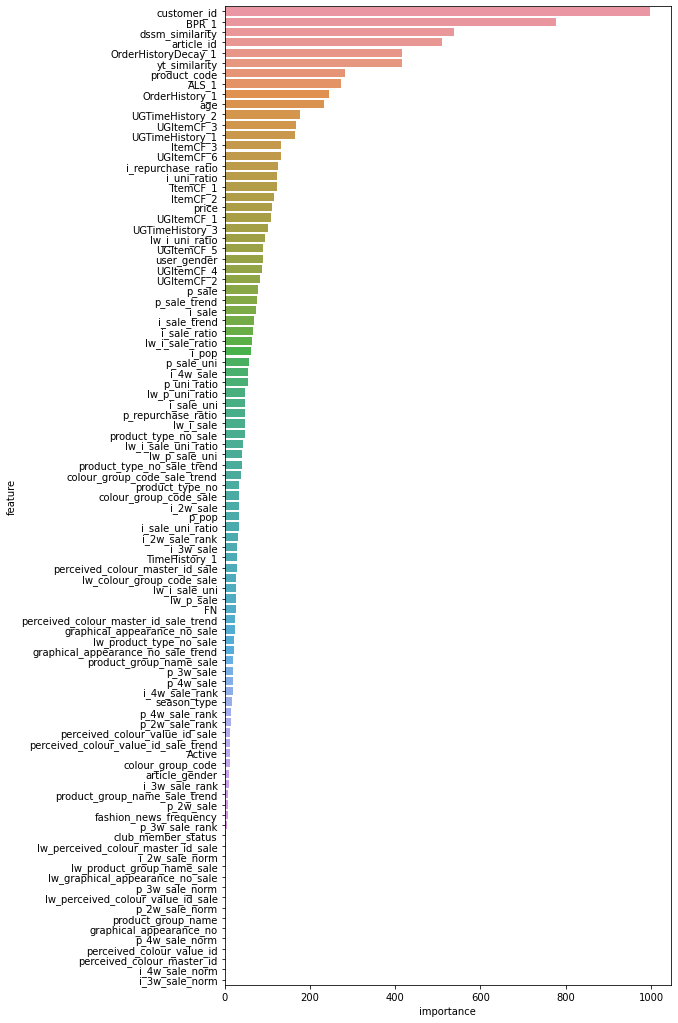

In [64]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 18))
sns.barplot(y="feature", x="importance", data=feat_importance)

### Validate

In [65]:
val_candidates = candidates[1]

In [66]:
def predict(ranker, candidates, batch_size = 5_000_000):
    probs = np.zeros(candidates.shape[0])
    for batch in range(0, candidates.shape[0], batch_size):
        outputs = ranker.predict(candidates.loc[batch : batch + batch_size - 1, feats])
        probs[batch : batch + batch_size] = outputs
    candidates["prob"] = probs
    pred_lgb = candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()
    return pred_lgb

In [67]:
pred = predict(ranker, val_candidates)

100%|██████████| 68984/68984 [00:11<00:00, 6217.30it/s] 


In [68]:
pred.head()

,customer_id,prediction
0,81,"[95218, 104554, 103109, 101720, 95254, 105445,..."
1,87,"[100229, 98607, 33869, 27906, 27908, 103584, 1..."
2,108,"[2220, 13043, 61306, 61305, 53894, 61304, 9203..."
3,118,"[104554, 95218, 103109, 101720, 104555, 99024,..."
4,180,"[95217, 95218, 105181, 104987, 74275, 81825, 3..."


In [69]:
label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

In [71]:
map_at_k(label["article_id"], label["prediction"], k=12)

# 0.02820525160663368 1-week add normalization
# 0.028936597823123886 4-week min_pos_rate 0.006 0.0274
# 0.029111989281461418 4-week drop full-negative customer
# 0.029165419468984943 3-week 0.0270
# 0.028694388096248934 4-week min_pos_rate 0.005 lr=0.03
# 0.028927037894290773 4-week min_pos_rate 0.005 lr=0.01
# 0.028936597823123886 4-week min_pos_rate 0.005 lr=0.01 max_depth=9, num_leaves=256

# 0.02184774486112968
# 0.021299757514744458
# 0.024265585916471977

# 0.025168746198396853

0.025168746198396853

In [60]:
recall_at_k(label["article_id"], label["prediction"], k=150)#0.18282943194751883

0.21695515873305862

### Test

In [26]:
del val_candidates, candidates
gc.collect()

44

In [27]:
test_candidates = pd.read_parquet(data_dir/"processed"/VERSION_NAME/"week0_candidate.pqt")
for feat in cat_features:
    test_candidates[feat] = test_candidates[feat].astype(cate_dict[feat])

In [28]:
test_pred = predict(ranker, test_candidates)

100%|██████████| 1371980/1371980 [01:29<00:00, 15394.20it/s]


In [29]:
idx2uid = pickle.load(open(data_dir/"index_id_map/user_index2id.pkl", "rb"))
idx2iid = pickle.load(open(data_dir/"index_id_map/item_index2id.pkl", "rb"))

In [30]:
def parse(x):
    l = ['0'+str(idx2iid[i]) for i in x]
    l = ' '.join(l[:12])
    return l

In [31]:
test_pred['prediction'] = test_pred['prediction'].progress_apply(lambda x: parse(x))

100%|██████████| 1371980/1371980 [00:18<00:00, 74629.08it/s]


In [32]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

In [33]:
del submission['prediction']
submission = submission.merge(test_pred, on='customer_id', how='left')
submission['customer_id'] = submission['customer_id'].map(idx2uid)

In [34]:
submission.to_csv('submission.csv', index=False)

In [35]:
submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0779781015 0573085028 0568601043 0918522001 06...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0918522001 0573085028 0918292001 0448509014 05...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0805000001 0918522001 0573085028 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0573085028 0918522001 0751471043 0673677002 05...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152001 0927530006 0791587001 0852584001 07...


### Submit

In [46]:
submit_msg = """
0.028927037894290773 4-week drop
---
OrderHistory(train, days=3, name='1'),
OrderHistory(train, days=7, name='2'),
OrderHistoryDecay(train, days=3, n=50, name='1'),
OrderHistoryDecay(train, days=7, n=50, name='2'),
ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
ItemPair(OrderHistoryDecay(train, days=3, n=50).retrieve(), name='3'),
ItemPair(OrderHistoryDecay(train, days=7, n=50).retrieve(), name='4'),
UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, name='1'),
UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50, name='2'),
UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=50),
TimeHistory(customer_list, last_week, n=50, name='1'),
TimeHistory(customer_list, last_3days, n=50, name='2'),
TimeHistoryDecay(customer_list, train, days=3, n=50, name='1'),
TimeHistoryDecay(customer_list, train, days=7, n=50, name='2'),
SaleTrend(customer_list, train, days=7, n=50)
---
min_pos_rate = 0.005
pivot
"""

In [47]:
submit_msg

"\n0.029111989281461418 4-week drop full negative user\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if w

In [60]:
# ! mkdir ~/.kaggle
# ! cp ../kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [65]:
# %pip install kaggle

     |████████████████████████████████| 58 kB 3.9 MB/s eta 0:00:011
     |████████████████████████████████| 78 kB 5.7 MB/s eta 0:00:011
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=2aaa2ba8e16413cb4c49862167277c1d8f29337d273f3f9b02c7f2a0d2b3a357
  Stored in directory: /root/.cache/pip/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [48]:
! kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f ./submission.csv -m '\n0.029111989281461418 4-week drop full negative user\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),\nSaleTrend(customer_list, train, 7, n=50 if week!=0 else 2)\n---\nmin_pos_rate = 0.006\npivot\n'

100%|████████████████████████████████████████| 258M/258M [00:11<00:00, 22.7MB/s]
Successfully submitted to H&M Personalized Fashion Recommendations